# ResNet-Based mmFace

In [8]:
import torch
import torch.nn as nn
# from torchvision.models import resnet18, ResNet18_Weights
# from torchvision.models import resnet50
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_classes = 21

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=50):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        layers = [block(self.inplanes, planes, stride, downsample)] + [block(planes, planes) for _ in range(blocks-1)]
        self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # TODO: MAYBE STOP HERE FOR 512D EMBEDDING???
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class MMFace(nn.Module):
    def __init__(self, num_classes=50):
        super(MMFace, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.maxpool =  nn.MaxPool2d(kernel_size=3)
        self.fc = nn.Sequential(
            nn.Linear(64*8*3, 32),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        # Flatten 64 x 8 x 3 to 1536 vector
        x = x.reshape(-1, 64*8*3)
        x = self.fc(x)
        x = self.fc2(x)

        return x

cuda


## Loading Dataset and Model

In [2]:
from dataset_builder import normalise, load_dataset_DL, load_dataset
from torchvision.transforms import Compose, ToTensor
import os
import numpy as np

def load_model(name, model, optimiser):
    epoch = 0
    loss_history, train_acc, val_acc = [], [], []
    try:
        checkpoint = torch.load(f"models/{name}")
        model.load_state_dict(checkpoint["model_state_dict"])
        optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
        epoch = checkpoint["epoch"]
        loss_history = checkpoint["loss_history"]
        train_acc = checkpoint["train_acc"]
        val_acc = checkpoint["val_acc"]
    except Exception as ex:
        print(ex)
    
    return epoch, loss_history, train_acc, val_acc

def load_history(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint["loss_history"], checkpoint["train_acc"], checkpoint["val_acc"]

frames = 250
# train, validation, test = load_dataset_DL(os.path.relpath("../../Soli/soli_realsense/data"), range(num_classes), batch_size=128, transform=Compose([normalise, ToTensor()]))
subjects = np.random.randint(0, num_classes, (4))
train, validation, test = load_dataset(os.path.relpath("../../Soli/soli_realsense/data"), range(4), batch_size=128)

100%|██████████| 4/4 [00:00<?, ?it/s]


Train: torch.Size([11999, 3, 32, 16])
Validation: torch.Size([1500, 3, 32, 16])
Test: torch.Size([1500, 3, 32, 16])
Allocated: 0.19 GB


## Hyperparameters + Loss + Optimiser

In [3]:
# from cnn import MMFace_Padding, MMFace

num_epochs = 16
learning_rate = 0.01

# model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes).to(device)
model = MMFace(4).to(device)

# model = resnet18(weights=ResNet18_Weights.DEFAULT)
# model = resnet50()
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = "random4.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)
model = model.to(device)
# for param in model.parameters():
#     param.requires_grad = True

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]:.4f}\n\tValidation Accuracy: {val_acc[-1]:.4f}")

[Errno 2] No such file or directory: 'models/random4.pt'


## Training
- Load training data in ***batches*** for every epoch, moving to `device`
  - `train_loader` = `[([data*], [labels*])*]`
- `model(data)` to predict label, then calculate loss between predictions and ground truth labels using `criterion(preds, labels)`
- Backpropagate to learn with `loss.backward()`, and update weights with `optimiser.step()`. Gradients must be reset to 0 after every update with `optimiser.zero_grad()` otherwise gradients will accumulate (default PyTorch).
- After every epoch, test model on validation set but can turn off gradients for faster evaluation using `with torch.no_grad()`.

In [4]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc, total = 0., 0., 0.

    for data, labels in tqdm(train):
        # Forward Pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()

        del data, labels, outputs
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc = 100*running_acc/total
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy: {avg_train_acc:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [avg_train_acc],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in validation:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del data, labels, outputs
        
        avg_val_acc = 100*correct/total
        print(f"\tValidation Accuracy: {avg_val_acc:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append(avg_val_acc)
    torch.save(model_checkpoint, f"models/{model_name}")


Epoch [0/15]:


100%|██████████| 94/94 [00:01<00:00, 50.99it/s]


	Average Train Loss: 1.3142
	Train Accuracy: 35.3446%
	Validation Accuracy: 42.4667%

Epoch [1/15]:


100%|██████████| 94/94 [00:01<00:00, 71.67it/s]


	Average Train Loss: 1.1998
	Train Accuracy: 44.3120%
	Validation Accuracy: 45.2667%

Epoch [2/15]:


100%|██████████| 94/94 [00:01<00:00, 75.67it/s]


	Average Train Loss: 1.1712
	Train Accuracy: 45.9538%
	Validation Accuracy: 46.4000%

Epoch [3/15]:


100%|██████████| 94/94 [00:01<00:00, 73.31it/s]


	Average Train Loss: 1.1576
	Train Accuracy: 47.0623%
	Validation Accuracy: 46.2667%

Epoch [4/15]:


100%|██████████| 94/94 [00:01<00:00, 74.01it/s]


	Average Train Loss: 1.1457
	Train Accuracy: 47.5206%
	Validation Accuracy: 46.3333%

Epoch [5/15]:


100%|██████████| 94/94 [00:01<00:00, 72.34it/s]


	Average Train Loss: 1.1358
	Train Accuracy: 48.1707%
	Validation Accuracy: 47.0000%

Epoch [6/15]:


100%|██████████| 94/94 [00:01<00:00, 75.45it/s]


	Average Train Loss: 1.1261
	Train Accuracy: 49.0041%
	Validation Accuracy: 46.7333%

Epoch [7/15]:


100%|██████████| 94/94 [00:01<00:00, 72.52it/s]


	Average Train Loss: 1.1158
	Train Accuracy: 49.6291%
	Validation Accuracy: 47.8667%

Epoch [8/15]:


100%|██████████| 94/94 [00:01<00:00, 76.93it/s]


	Average Train Loss: 1.1048
	Train Accuracy: 50.5125%
	Validation Accuracy: 47.4667%

Epoch [9/15]:


100%|██████████| 94/94 [00:01<00:00, 74.41it/s]


	Average Train Loss: 1.0941
	Train Accuracy: 51.3959%
	Validation Accuracy: 47.7333%

Epoch [10/15]:


100%|██████████| 94/94 [00:01<00:00, 77.27it/s]


	Average Train Loss: 1.0825
	Train Accuracy: 52.0543%
	Validation Accuracy: 48.2667%

Epoch [11/15]:


100%|██████████| 94/94 [00:01<00:00, 72.02it/s]


	Average Train Loss: 1.0708
	Train Accuracy: 52.9044%
	Validation Accuracy: 48.2667%

Epoch [12/15]:


100%|██████████| 94/94 [00:01<00:00, 71.63it/s]


	Average Train Loss: 1.0592
	Train Accuracy: 53.7711%
	Validation Accuracy: 47.8667%

Epoch [13/15]:


100%|██████████| 94/94 [00:01<00:00, 75.37it/s]


	Average Train Loss: 1.0434
	Train Accuracy: 54.2462%
	Validation Accuracy: 48.1333%

Epoch [14/15]:


100%|██████████| 94/94 [00:01<00:00, 72.50it/s]


	Average Train Loss: 1.0262
	Train Accuracy: 55.1629%
	Validation Accuracy: 47.7333%

Epoch [15/15]:


100%|██████████| 94/94 [00:01<00:00, 72.63it/s]

	Average Train Loss: 1.0059
	Train Accuracy: 56.1630%
	Validation Accuracy: 46.2000%


## Testing

In [5]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        del data, labels, outputs
    
    print(f"Test Accuracy of mmFace: {100*correct/total:.4f}%")

Test Accuracy of mmFace: 47.6000%


# Evaluation

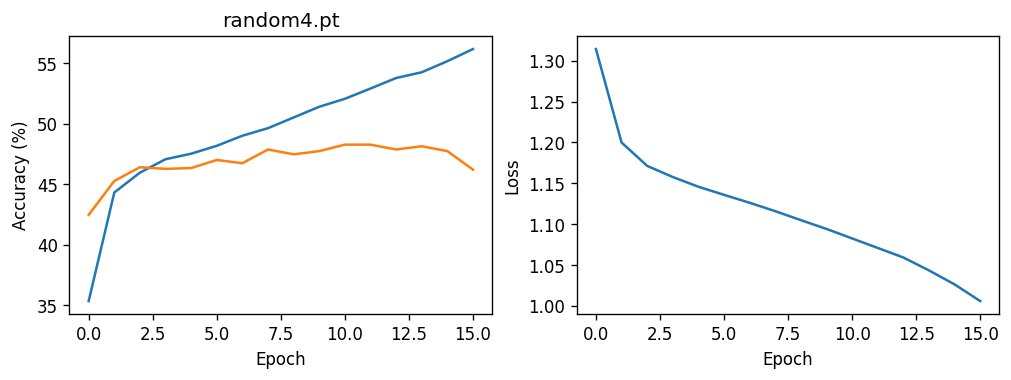

In [6]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subjects = anon_names
# subjects = range(num_classes)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subjects, columns=subjects)
plt.figure(figsize = (12,7))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

ValueError: Shape of passed values is (4, 4), indices imply (13, 13)

# Evaluation

<Axes: >

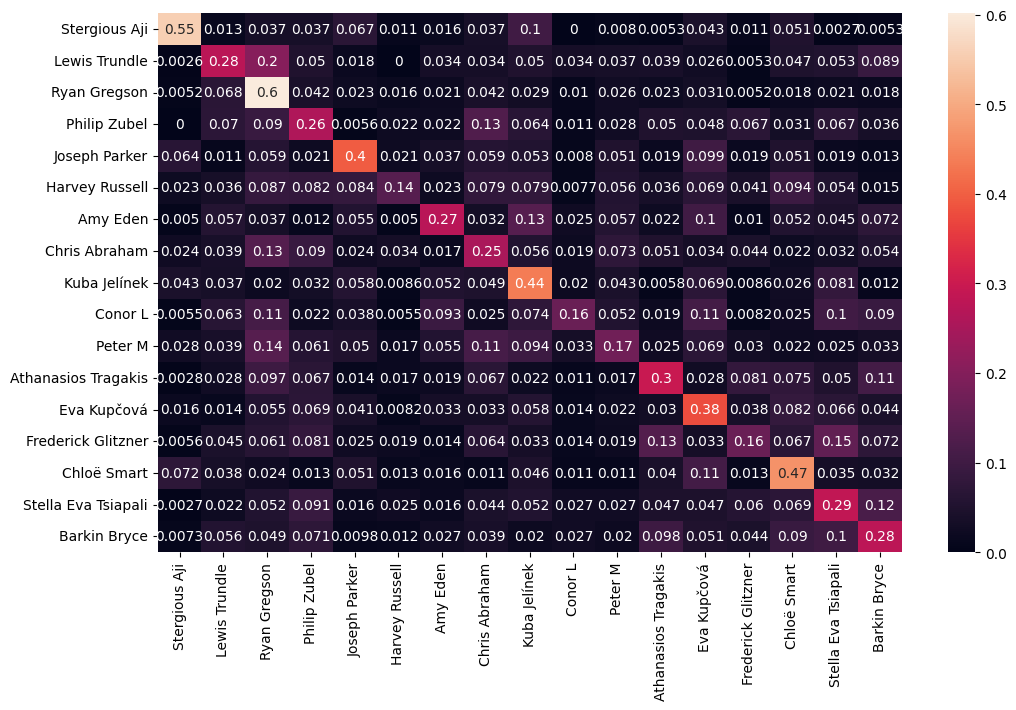

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) # Feed Network

        _, predicted = torch.max(outputs.data, 1)
        # predicted = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        predicted = predicted.cpu().numpy()
        y_pred.extend(predicted) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in anon_names],
                     columns = [i for i in anon_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)